**Introduzione**

In questo progetto di face detection, l'obiettivo è identificare la presenza di volti in un'immagine. La soluzione proposta si basa su un approccio di classificazione binaria, dove le immagini vengono suddivise in due classi: positiva (etichettata con 1) se l'immagine è un volto e negativa (etichettata con 0) se non lo è.

Inizialmente, viene creato un dataset bilanciato con esempi positivi e negativi. Successivamente, le immagini del dataset vengono trasformate utilizzando il metodo HOG (Histogram of Oriented Gradients), una tecnica di estrazione delle feature ampiamente utilizzata per la rappresentazione delle caratteristiche di un'immagine.[1][2]

Una volta estratte le feature HOG, viene addestrato un modello di classificazione Support Vector Machine (SVM) che richiede poche risorse di calcolo. Questo modello viene addestrato utilizzando le feature HOG come input e le relative etichette di classe.

Successivamente, per individuare i volti nell'immagine, viene utilizzata una tecnica di sliding window con varie dimensioni e uno step fissato. Questa finestra scorre sull'immagine, estrae i le porzioni di immagine corrispondenti e li fornisce al modello addestrato per la classificazione. Il modello classifica ogni pezzo di immagine come volto o non volto.

Infine, per gestire le sovrapposizioni tra le finestre e ottenere una singola e accurata identificazione dei volti, viene applicata una tecnica di non-maximum suppression. Questo passaggio elimina le sovrapposizioni tra le finestre, conservando solo le posizioni dei volti con la massima probabilità di appartenere alla classe positiva.

Perciò, suddividiamo il resto del notebook in tre parti:


1.   Creazione del dataset
2.   Sviluppo del modello
3.   Implementazione della pipeline finale



**Creazione del dataset**

In questa sezione viene creato un dataset bilanciato in cui nella classe positiva c'è un campione casuale di 600 volti presi da [3]. Per la classe negativa, vengono prese 300 osservazioni da un dataset di oggetti [4] e 300 osservazioni da un dataset di paesaggi [5].

In particolare, per questo problema è abbbastanza difficile trovare un campione che rappresenti bene cosa "non è un volto" in una foto, in quanto questa definizione è abbastanza vaga. Perciò, la classe negativa è stata costruita a partire da molteplici scenari, che rappresentino paesaggi naturali, edifici, strade e oggetti.

In [1]:
import os
import random
import shutil
import glob
import numpy as np
import cv2
from PIL import Image
import pandas as pd
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split , KFold
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score
from google.colab.patches import cv2_imshow
from sklearn.svm import SVC
from imutils.object_detection import non_max_suppression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

Scarichiamo i tre dataset da Kaggle:

In [ ]:
!pip install -q kaggle


from google.colab import files
files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d jessicali9530/coil100
!unzip coil100.zip -d objects  #oggetti

!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip -d seg_train  #sfondi

!kaggle datasets download -d badasstechie/celebahq-resized-256x256 #facce
!unzip celebahq-resized-256x256.zip -d faces_celeb

Scriviamo una funzione per poter organizzare in due cartelle su colab la classe positiva e la classe negativa.

In [3]:
def organize_folder( source_folder, format, destination_folder, num_images ):

  files_jpg = glob.glob(source_folder + f"/**/*.{format}", recursive=True)

  random.seed(2)

  selected_images = random.sample(files_jpg, num_images)

  if not os.path.exists(destination_folder):
      os.makedirs(destination_folder)

  for image in selected_images :
      src = os.path.join(source_folder, image)
      dst = os.path.join(destination_folder, os.path.basename(image))
      shutil.copyfile(src, dst)

In [4]:
organize_folder("/content/faces_celeb/celeba_hq_256", "jpg" , "/content/faces", 600 )

In [5]:
organize_folder("/content/objects/coil-100/coil-100", "png", "/content/not_faces", 300)

In [6]:
organize_folder("/content/seg_train/seg_train/seg_train", "jpg", "/content/not_faces", 300)

A questo punto riscaliamo le immagini alla dimensione più piccola che è quella degli oggetti ovvero 128x128 e salviamo le immagini in una nuova cartella, una per la classe positiva e una per la classe negativa.

In [7]:
def resize_pics( path_resized , source_path ):
  if not os.path.exists(path_resized):
    os.makedirs(path_resized)

  for immagine in os.listdir(source_path):
      open_image = Image.open(f"{source_path}/{immagine}")
      image_resized = open_image.resize((128, 128))
      image_resized.save(f"{path_resized}/{immagine}")

In [8]:
resize_pics("/content/faces_resized" , "/content/faces")
resize_pics("/content/not_faces_resized", "/content/not_faces")

A questo punto siamo pronti per creare la rappresentazione HOG delle immagini del dataset. In poche parole, l'immagine viene divisa in piccole regioni chiamate celle e per ciascuna di queste celle si calcola un istogramma delle direzioni dei gradienti di intensità dei pixel. Questi istogrammi vengono poi normalizzati per migliorare la robustezza nei confronti di variazioni nell'illuminazione e nelle ombre.

In [9]:
X = []
for immagine in os.listdir("/content/faces_resized"):
  x = cv2.imread(f"/content/faces_resized/{immagine}", cv2.IMREAD_GRAYSCALE)
  features, _ = hog(x, orientations=9, pixels_per_cell=(4, 4),
                          cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

  X.append(features)

In [10]:
Z = []
for immagine in os.listdir("/content/not_faces_resized"):
  z = cv2.imread(f"/content/not_faces_resized/{immagine}", cv2.IMREAD_GRAYSCALE)
  features, _ = hog(z, orientations=9, pixels_per_cell=(4, 4),
                          cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

  Z.append(features)

Costruiamo ora il dataset con le due liste X e Z a cui aggiungiamo l'etichetta di classe.

In [11]:
faces = pd.DataFrame(X)
faces['is_face'] = 1
not_faces = pd.DataFrame(Z)
not_faces['is_face'] = 0
df = pd.concat([faces, not_faces])

Controlliamo che il dataset sia bilanciato e il numero di osservazioni sia 1200.

In [12]:
df.shape, df['is_face'].value_counts()

((1200, 34597),
 1    600
 0    600
 Name: is_face, dtype: int64)

Le features restituite dalla rappresentazione HOG sono già normalizzate, quindi in questa fase di preprocessing ci limitiamo a controllare che non ci siano valori NaN.

In [13]:
mask_nan = df.isna().any(axis=1)
rows_with_nan = df[mask_nan]
rows_with_nan

,0,1,2,3,4,5,6,7,8,9,...,34587,34588,34589,34590,34591,34592,34593,34594,34595,is_face


**Sviluppo del modello**

A questo punto, ci troviamo con un dataset bilanciato che presenta un elevato numero di features. È importante notare che un modello sviluppato su un dataset con un'elevata dimensione delle features rispetto al numero di osservazioni potrebbe essere soggetto ad overfitting. Pertano diventa importante ridurre la dimensionalità, utlizzando ad esempio l'analisi delle componenti principali. Per semplicità verranno provati due valori abbastanza alti per il numero di componenti (200 e 300) in modo da mantenere una buona rappresentatività pur diminuendo di molto il numero di features.

Nella cella seguente, scriviamo una pipeline per trovare la migliore configurazione di parametri per quanto riguarda il numero di componenti principali e per il parametro C di SVC. Cerchiamo il parametro C tra due valori molto bassi per ridurre il rischio di overfitting. Infatti C rappresenta quanto vogliamo penalizzare gli errori di classificazione; più alto è questo valore e più il modello rischia di soffrire di overfitting, più basso è il valore e più saranno ammessi errori e si ridurrà di conseguenza il rischio di overfitting.

In [14]:
pipe_svc = make_pipeline(
    PCA(),
    SVC(probability = True, random_state = 7)
)

components = [200, 300]
param_range = [0.01, 0.1]
param_grid = [
              { 'pca__n_components': components,
                'svc__C': param_range,
                'svc__kernel': ['rbf']}  ]

grid = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    refit=True,
    n_jobs=-1
)



X = df.drop('is_face', axis = 1).values
Y = df['is_face'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=30)


gs = grid.fit(X_train, Y_train)
gs.best_score_
gs.best_params_

{'pca__n_components': 200, 'svc__C': 0.1, 'svc__kernel': 'rbf'}

In [15]:
clf = gs.best_estimator_
_ = clf.fit(X_train, Y_train)
print(f'Test accuracy: {clf.score(X_test, Y_test):.3f}')

Test accuracy: 0.989


**Creazione della pipeline**

Nella cella seguente andiamo a definire una funzione che consente di generare finestre scorrevoli su un'immagine, restituendo le coordinate di ogni finestra e la parte corrispondente dell'immagine.

In [16]:
def sliding_window(image, step, window_size):
    for y in range(0, image.shape[0] - window_size[1], step):
        for x in range(0, image.shape[1] - window_size[0], step):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

Ora, considerato che le immagini provengono da una macchinetta fotografica per bambini, vengono fissate tre dimensioni per la sliding window: 50x50, 60x60 e 100x100, considerando che le immagini siano relativamente piccole, ad esempio 300x300 pixel, e che si voglia individuare facce di varie dimensioni all'interno di esse (piccole, medie o grandi).

Successivamente, ogni sliding window viene utilizzata come input per il modello svm precedentemente addestrato. Il modello valuta la probabilità che la regione corrispondente alla sliding window contenga una faccia. Se la probabilità supera una soglia prestabilita, ad esempio 0.98, allora si considera che quella regione contenga una faccia e si salvano le coordinate del bounding box corrispondente.

Dopo l'individuazione delle regioni che superano la soglia di probabilità tramite la sliding window, viene applicata una tecnica chiamata non-maximum suppression (NMS). Questa tecnica serve a eliminare i bounding box sovrapposti e a mantenere solo il bounding box con la probabilità più alta. In questo modo si evita il rilevamento multiplo della stessa faccia.

Quindi, le fasi descritte in questa cella vengono integrate in una classe per poi essere inserite in una pipeline sklearn. Per consentire la scrittura di questa pipeline sklearn c'è bisogno di definire i metodi fit e transform della classe. Nel fit non c'è bisogno di fare nulla e nel transform andiamo ad inserire gli step del processo.

In [17]:
class FaceDetector(BaseEstimator, TransformerMixin):


    def __init__(self, clf, window_sizes=[(50, 50), (60, 60), (100, 100)], threshold=0.98):
        self.clf = clf
        self.window_sizes = window_sizes
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        image = cv2.imread(X)
        gray_image = cv2.imread(X, cv2.IMREAD_GRAYSCALE)
        faces = []
        score = []

        for window_size in self.window_sizes:
            for (x, y, window) in sliding_window(gray_image, step=10, window_size=window_size):

                resized_window = cv2.resize(window, (128, 128))
                features, _ = hog(resized_window, orientations=9, pixels_per_cell=(4,4),
                                  cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

                y_proba = self.clf.predict_proba(features.reshape(1,-1))
                y_pred = self.clf.predict(features.reshape(1,-1))


                if y_proba[0][1] >= self.threshold:
                    faces.append([x, y, x+window_size[0], y+window_size[1]])
                    score.append(y_proba[0][1])


        boxes = np.array(faces)
        prob = np.array(score)
        selected_boxes = non_max_suppression(boxes, prob , overlapThresh=0.3)


        for box in selected_boxes:
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        cv2_imshow(image)

        return selected_boxes

In [18]:
pipeline = Pipeline([
    ('face_detector', FaceDetector(clf))
])

Proviamo questa pipeline nelle due celle seguenti.

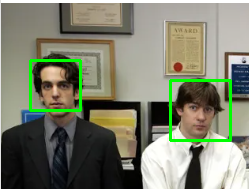

array([[170,  80, 230, 140],
       [ 30,  60,  80, 110]])

In [19]:
pipeline.transform("/content/p2.png")

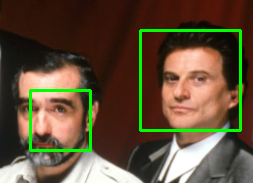

array([[140,  30, 240, 130],
       [ 30,  90,  90, 150]])

In [20]:
pipeline.transform("/content/goodfellas3.png")

**Bibliografia**\
[1] https://sites.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj5/html/pkundra3/index.html \
[2] https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78 \
[3] https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256 \
[4] https://www.kaggle.com/datasets/jessicali9530/coil100 \
[5] https://www.kaggle.com/datasets/puneet6060/intel-image-classification